In [1]:
library(nlme)
library(ggplot2)
library(lme4)
library(MASS)
library(car)
library(lattice)
library(scales)

Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList



In [2]:
tab <- read.csv("3D_WinCF_GenusLevel.csv")

In [3]:
head(tab)

X.OTU.ID,QiitaID,Patient,Treatment,Depth,D_0__Bacteria.D_1__Proteobacteria.D_2__Gammaproteobacteria.D_3__Pseudomonadales.D_4__Pseudomonadaceae.D_5__Pseudomonas,D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Lactobacillales.D_4__Streptococcaceae.D_5__Streptococcus,D_0__Bacteria.D_1__Proteobacteria.D_2__Gammaproteobacteria.D_3__Xanthomonadales.D_4__Xanthomonadaceae.D_5__Luteimonas,D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Prevotellaceae.D_5__Prevotella,D_0__Bacteria.D_1__Firmicutes.D_2__Negativicutes.D_3__Selenomonadales.D_4__Veillonellaceae.D_5__Veillonella,⋯,D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Clostridiaceae.1.D_5__Clostridium.sensu.stricto.12,D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Frankiales.D_4__Geodermatophilaceae.D_5__Modestobacter,D_0__Bacteria.D_1__Fibrobacteres.D_2__Fibrobacteria.D_3__Fibrobacterales.D_4__Fibrobacteraceae.D_5__uncultured,D_0__Bacteria.D_1__Proteobacteria.D_2__Betaproteobacteria.D_3__Burkholderiales.D_4__Comamonadaceae.D_5__Mitsuaria,D_0__Bacteria.D_1__Proteobacteria.D_2__Betaproteobacteria.D_3__Nitrosomonadales.D_4__Gallionellaceae.D_5__Ferriphaselus,D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Bacillales.D_4__Bacillaceae.D_5__Vulcanibacillus,D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Lachnospiraceae.D_5__Syntrophococcus,D_0__Bacteria.D_1__Proteobacteria.D_2__Gammaproteobacteria.D_3__Oceanospirillales.D_4__Oceanospirillaceae.D_5__uncultured,D_0__Bacteria.D_1__Actinobacteria.D_2__Acidimicrobiia.D_3__Acidimicrobiales.D_4__uncultured.D_5__uncultured.Acidimicrobidae.bacterium,D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae.D_5__Methanobrevibacter
10863.34.1.a,10863,34,NT,1,0.9530526,0.004254612,0.000293421,6.84650e-05,0.000068465,⋯,0,0,0,0,0,0,0,0,0,0
10863.34.2,10863,34,NT,2,0.7471585,0.071018345,0.000514150,4.37575e-05,0.008685854,⋯,0,0,0,0,0,0,0,0,0,0
10863.34.3,10863,34,NT,3,0.6210526,0.000000000,0.000000000,0.00000e+00,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
10863.34.4,10863,34,NT,4,0.2160556,0.134588897,0.000579937,1.37735e-04,0.263066707,⋯,0,0,0,0,0,0,0,0,0,0
10863.34.5,10863,34,NT,5,0.0000000,0.000000000,0.000000000,0.00000e+00,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
10863.34.6,10863,34,NT,6,0.1734918,0.167871842,0.000519231,5.34502e-05,0.378778739,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
# Inform the index of Patient, Depth and pseudomonas counts 
# in this order
#'pseudo' names the bacterial column. Use pseudo everytime so I don't have to change it everywhere
tab2 <- tab[, c(3,4,5,6)]
colnames(tab2)[4] <- "pseudo"

In [5]:
tab3 <- tab2
tab3$pseudo <- tab3$pseudo+1

In [6]:
tab3[,2] <- as.character(tab3[,2]) 
tab3[tab3[,2]=='NT',2] <- 'AT' 
tab3[,2] <- as.factor(tab3[,2])
dim(tab3)

[1] 579   4

In [7]:
head(tab3)

Patient,Treatment,Depth,pseudo
34,AT,1,1.953053
34,AT,2,1.747158
34,AT,3,1.621053
34,AT,4,1.216056
34,AT,5,1.000000
34,AT,6,1.173492


In [8]:
table(tab3$Treatment)


 AT  BC  TB 
200 189 190 

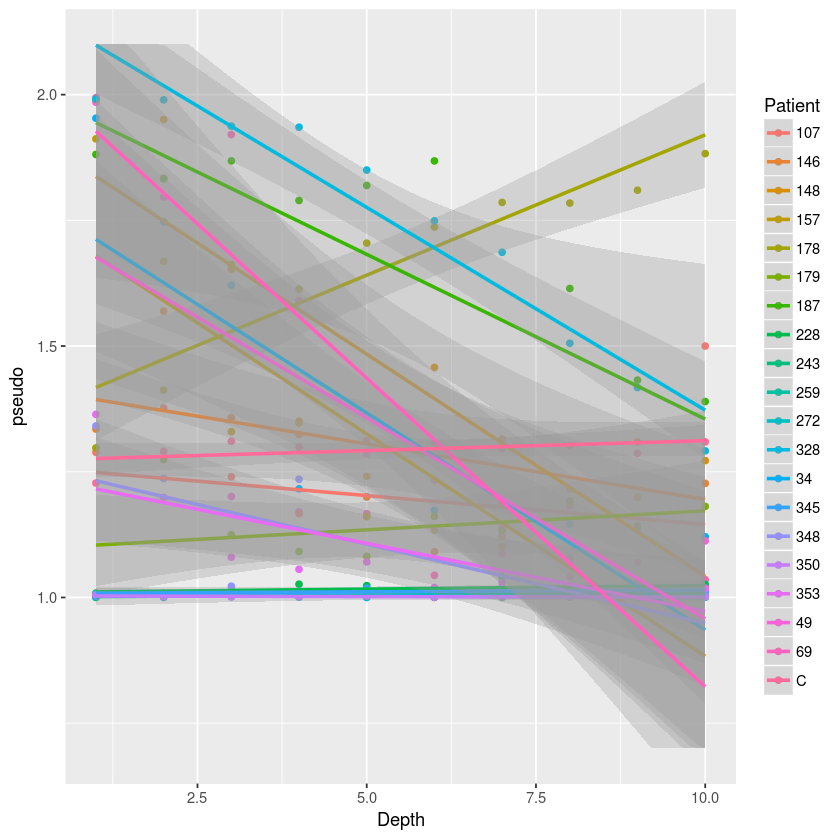

In [9]:
ggplot(tab3[tab3[,2]=="AT",],aes(x=Depth,y=pseudo,colour=Patient))+geom_point()+
    geom_smooth(method="lm",alpha=0.3)+
    scale_y_continuous(limits=c(0.7,2.1),oob=squish)

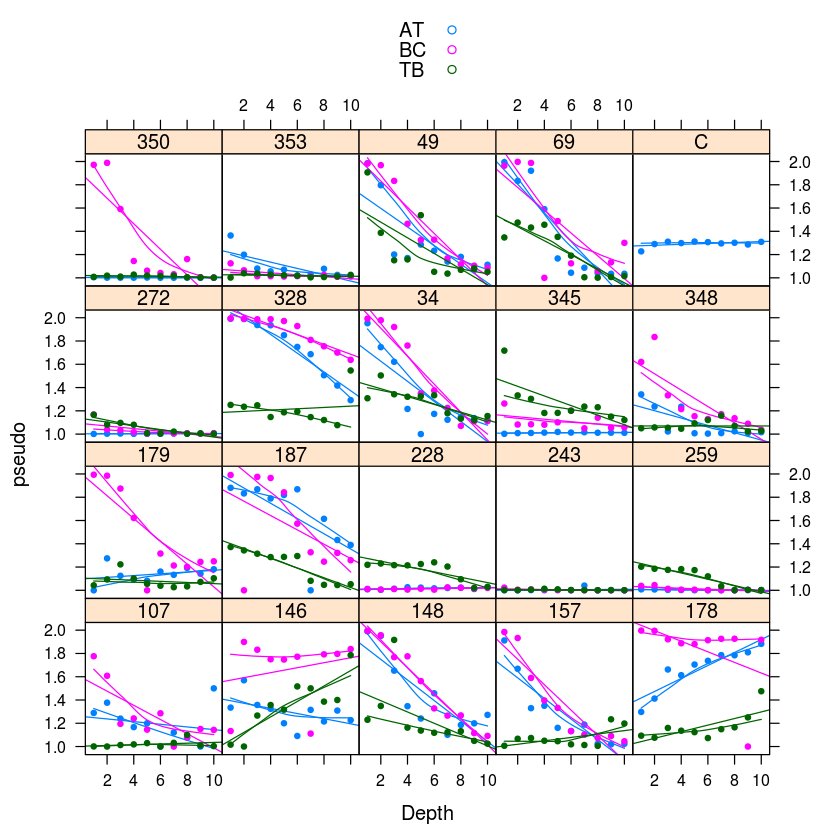

In [10]:
xyplot(pseudo ~ Depth | Patient, data=tab3, type=c("p", "r", "smooth"), group = Treatment, , auto.key = TRUE,  span=1, pch=20)

We want to fit a generalized linear mixed-effects model, to account for non-normal distribution of data (generalized) and mixed-effect to assign a random effect to indiviual, as data were gathered over time
on the same individuals. 

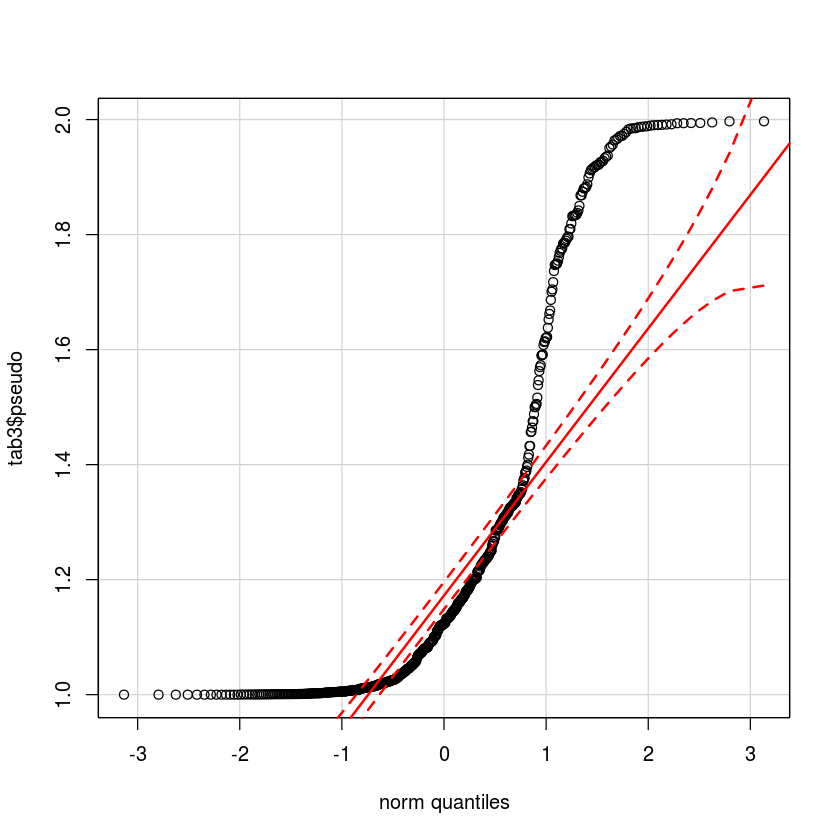

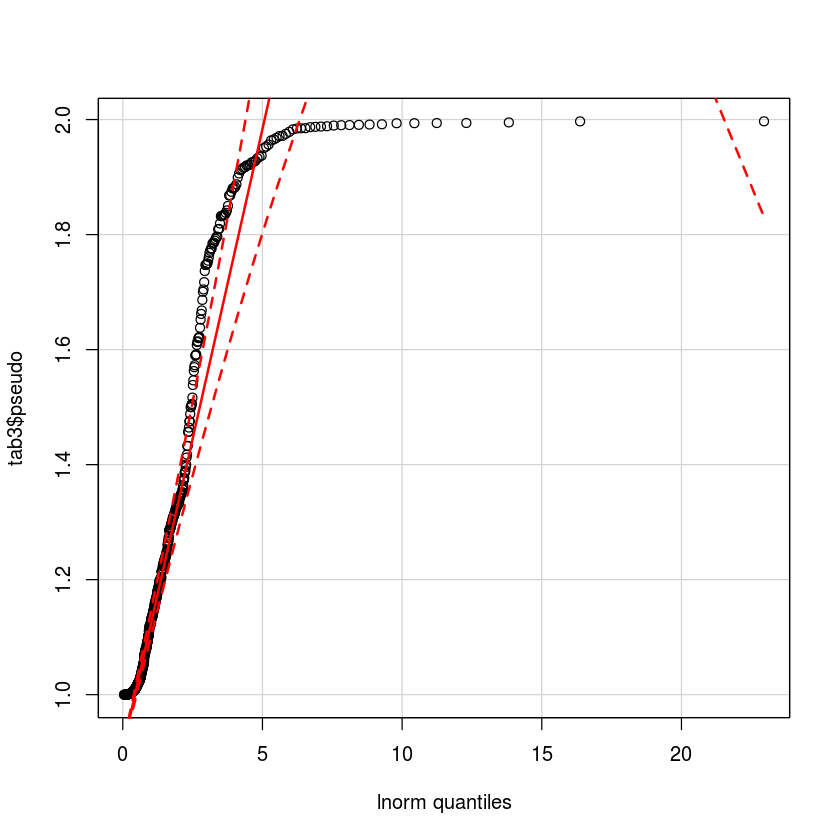

In [11]:
qqp(tab3$pseudo, "norm")
qqp(tab3$pseudo, "lnorm")

In [12]:
PQL <- glmmPQL(pseudo ~ Depth*Treatment, ~1 | Patient, family = gaussian(link = "log"), data=tab3) 
summary(PQL)

iteration 1
iteration 2
iteration 3
iteration 4


Linear mixed-effects model fit by maximum likelihood
 Data: tab3 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | Patient
        (Intercept)  Residual
StdDev:   0.1447812 0.1986534

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects: pseudo ~ Depth * Treatment 
                       Value  Std.Error  DF   t-value p-value
(Intercept)        0.3634271 0.03967703 554  9.159635  0.0000
Depth             -0.0275237 0.00390273 554 -7.052440  0.0000
TreatmentBC        0.1616188 0.03074333 554  5.257036  0.0000
TreatmentTB       -0.1877591 0.03504459 554 -5.357719  0.0000
Depth:TreatmentBC -0.0149512 0.00538735 554 -2.775233  0.0057
Depth:TreatmentTB  0.0164372 0.00588961 554  2.790877  0.0054
 Correlation: 
                  (Intr) Depth  TrtmBC TrtmTB Dp:TBC
Depth             -0.497                            
TreatmentBC       -0.420  0.641                     
TreatmentTB       -0.368  0.562  0.481              
Depth:TreatmentBC  0.360 -0.724 

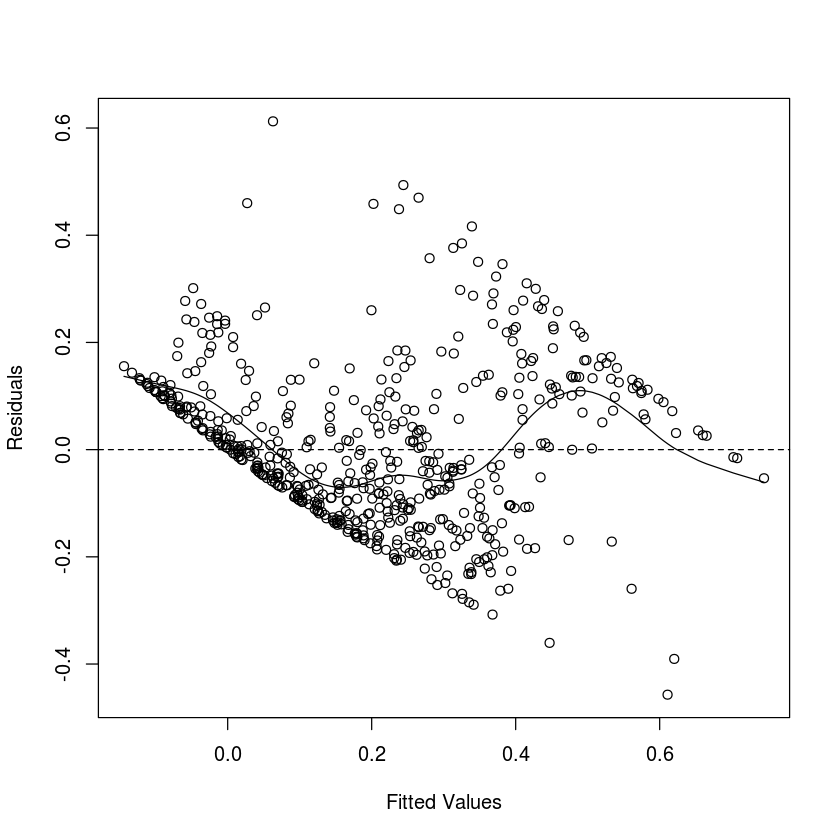

In [13]:
plot(fitted(PQL), residuals(PQL), xlab = "Fitted Values", ylab = "Residuals")
abline(h = 0, lty = 2)
lines(smooth.spline(fitted(PQL), residuals(PQL)))

cite:
http://www.sciencedirect.com/science/article/pii/S0169534709000196


http://www.springer.com/us/book/9780387874579